<a href="https://colab.research.google.com/github/mltngpot/machine-vision/blob/main/Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# determine working directory
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# connect with github
!git clone https://github.com/mltngpot/machine-vision.git

In [9]:
# set video path
SOURCE_VIDEO_PATH = f"{HOME}/machine-vision/data/cropped-I94-US20-35.1.mp4"

In [5]:
!pip install ultralytics supervision # already installed

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()


#!pip install supervision # already installed

from IPython import display
display.clear_output()

import supervision as sv
print('supervision.__version__:', sv.__version__)

supervision.__version__: 0.23.0


In [6]:
# select model
MODEL = 'yolov8x.pt'

In [7]:
# import YOLO and create model
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()



# dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest : car, motorcycle, bus, and truck
selected_classes = [2, 3, 5, 7]

100%|██████████| 131M/131M [00:00<00:00, 264MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


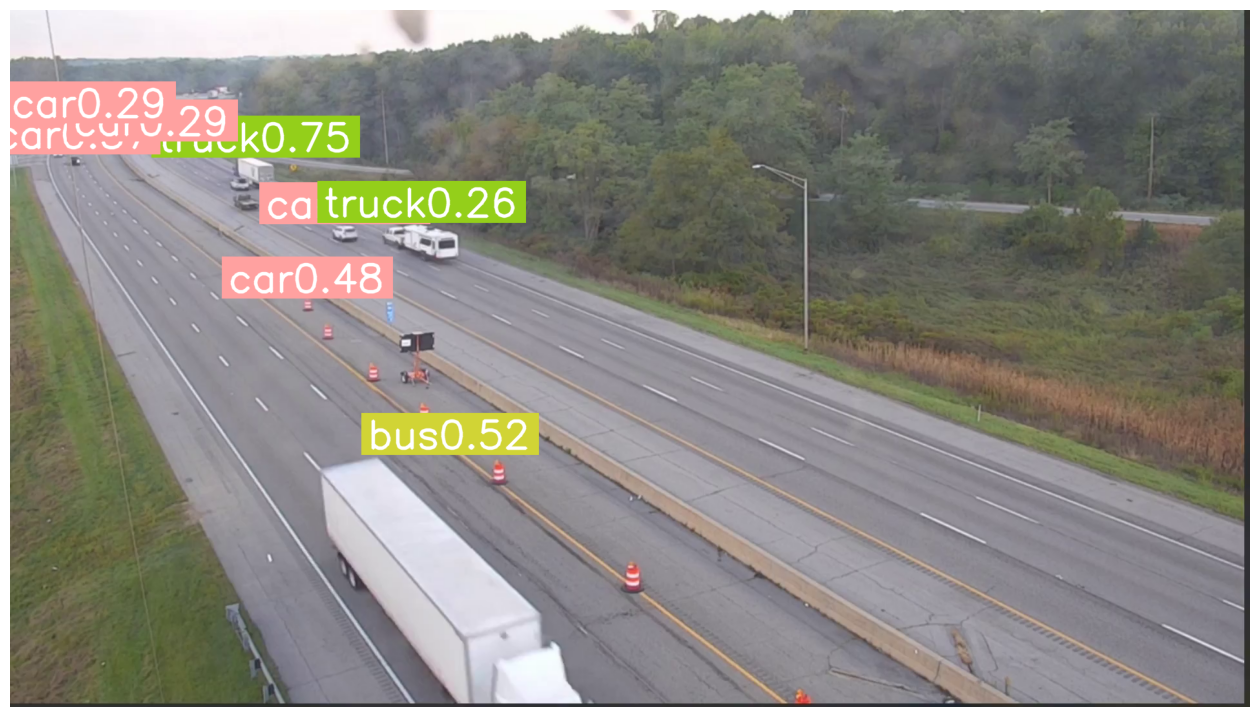

In [10]:
# initial frame generations for annotations
import supervision as sv
import numpy as np




# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# Note: since this tutorial, the API has changed, so I am changing some parts after reading API
# create instance of LabelAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2, text_position=sv.Position.TOP_CENTER)
# get first frame of the video
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes from above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f'{CLASS_NAMES_DICT[class_id]}{confidence:0.2f}'
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

# settings for counting line
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [11]:
# output video path
TARGET_VIDEO_PATH = f'{HOME}/vehicle-counting-results-with-counter.mp4'

In [12]:
# get video info
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=29, total_frames=829)

In [ ]:
# create bytetracker instance
# defaults track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)
byte_tracker = sv.ByteTrack()

# create videoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2, text_position=sv.Position.TOP_CENTER)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)